In [1]:
%matplotlib inline
%load_ext Cython

import numpy as np
import pymc3 as pm
import theano.tensor as tt

/home/matthew/.conda/envs/testing/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [2]:
%%cython

import numpy as np
cimport numpy as np

# define your really complicated model that uses load of external codes
def model(theta, x):
    """
    A straight line!
    """
    m, c = theta # unpack line gradient and y-intercept

    return m*x + c

# define your really complicated likelihood function that uses loads of external codes
def loglike(theta, x, data, sigma):
    """
    A Gaussian likelihood function for a model with parameters given in theta
    """
    
    mymodel = model(theta, x)
    
    return -(0.5/sigma**2)*np.sum((data - mymodel)**2)

In file included from /home/matthew/.conda/envs/testing/lib/python3.6/site-packages/numpy/core/include/numpy/ndarraytypes.h:1823:0,
                 from /home/matthew/.conda/envs/testing/lib/python3.6/site-packages/numpy/core/include/numpy/ndarrayobject.h:18,
                 from /home/matthew/.conda/envs/testing/lib/python3.6/site-packages/numpy/core/include/numpy/arrayobject.h:4,
                 from /home/matthew/.cache/ipython/cython/_cython_magic_d05de1388e5a922464ef78c9fd19adff.c:587:
/home/matthew/.conda/envs/testing/lib/python3.6/site-packages/numpy/core/include/numpy/npy_1_7_deprecated_api.h:15:2: warning: #warning "Using deprecated NumPy API, disable it by " "#defining NPY_NO_DEPRECATED_API NPY_1_7_API_VERSION" [-Wcpp]
 #warning "Using deprecated NumPy API, disable it by " \
  ^


In [6]:
# define a theano Op for our likelihood function
class LogLike(tt.Op):
    
    itypes = [tt.dvector] # expects a vector of parameter values when called
    otypes = [tt.dscalar] # outputs a single scalar value (the log likelihood)

    def __init__(self, loglike, data, x, sigma):
        """
        Initialise with various things that the function requires. Below
        are the things that are needed in this particular example.
        
        Parameters
        ----------
        loglike:
            The log-likelihood (or whatever) function we've defined
        data:
            The "observed" data that our log-likelihood function takes in
        x:
            The dependent variable (aka 'x') that our model requires
        sigma:
            The noise standard deviation that out function requires.
        """
        
        # add inputs as class attributes
        self.likelihood = loglike
        self.data = data
        self.x = x
        self.sigma = sigma

    def perform(self, node, inputs, outputs):
        # the method that is used when calling the Op
        theta, = inputs  # this will contain my variables
 
        # call the log-likelihood function
        logl = self.likelihood(theta, self.x, self.data, self.sigma)

        outputs[0][0] = np.array(logl) # output the log-likelihood

In [7]:
# set up our data
N = 10  # number of data points
sigma = 1.  # standard deviation of noise
x = np.linspace(0., 9., N)

mtrue = 0.4  # true gradient
ctrue = 3.   # true y-intercept

truemodel = model([mtrue, ctrue], x)

# make data
data = sigma*np.random.randn(N) + truemodel

ndraws = 1000
nburn = 500

# use PyMC3 to sampler from log-likelihood
with pm.Model():
    # uniform priors on m and c
    m = pm.Uniform('m', lower=-10., upper=10.)
    c = pm.Uniform('c', lower=-10., upper=10.)

    # create our Op
    logl = LogLike(loglike, data, x, sigma)
    
    # convert m and c to a tensor vector
    theta = tt.as_tensor_variable([m, c])
    
    # use a DensityDist
    pm.DensityDist('likelihood', lambda v: logl(v), observed={'v': theta})
    
    trace = pm.sample(ndraws, tune=nburn, discard_tuned_samples=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Initializing NUTS failed. Falling back to elementwise auto-assignment.
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Slice: [c]
>Slice: [m]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:01<00:00, 2056.11draws/s]
/home/matthew/.conda/envs/testing/lib/python3.6/site-packages/mkl_fft/_numpy_fft.py:1044: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  output = mkl_fft.rfftn_numpy(a, s, axes)
The number of effective samples is smaller than 25% for some parameters.


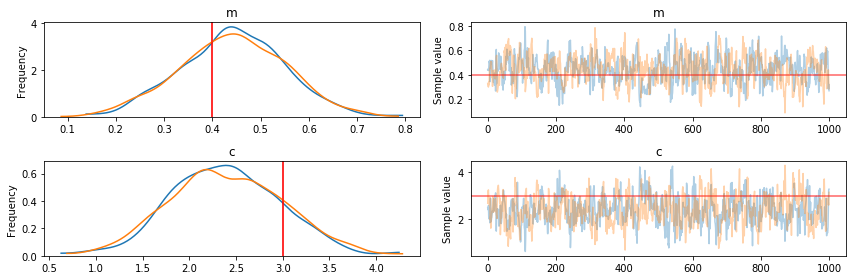

In [8]:
# plot the traces
_ = pm.traceplot(trace, lines={'m': mtrue, 'c': ctrue})

In [11]:
import warnings

def derivatives(vals, func, releps=1e-3, abseps=None, mineps=1e-9, reltol=1e-3,
                epsscale=0.5):
    """
    Calculate the partial derivatives of a function at a set of values. The
    derivatives are calculated using the central difference, using an iterative
    method to check that the values converge as step size decreases.

    Parameters
    ----------
    vals: array_like
        A set of values, that are passed to a function, at which to calculate
        the gradient of that function
    func:
        A function that takes in an array of values.
    releps: float, array_like, 1e-3
        The initial relative step size for calculating the derivative.
    abseps: float, array_like, None
        The initial absolute step size for calculating the derivative.
        This overrides `releps` if set.
        `releps` is set then that is used.
    mineps: float, 1e-9
        The minimum relative step size at which to stop iterations if no
        convergence is achieved.
    epsscale: float, 0.5
        The factor by which releps if scaled in each iteration.
        
    Returns
    -------
    grads: array_like
        An array of gradients for each non-fixed value.
    """

    grads = np.zeros(len(vals))

    # maximum number of times the gradient can change sign
    flipflopmax = 10.

    # set steps
    if abseps is None:
        if isinstance(releps, float):
            eps = np.abs(vals)*releps
            eps[eps == 0.] = releps # if any values are zero set eps to releps
            teps = releps*np.ones(len(vals))
        elif isinstance(releps, (list, np.ndarray)):
            if len(releps) != len(vals):
                raise ValueError("Problem with input relative step sizes")
            eps = np.multiply(np.abs(vals), releps)
            eps[eps == 0.] = np.array(releps)[eps == 0.]
            teps = releps
        else:
            raise RuntimeError("Relative step sizes are not a recognised type!")
    else:
        if isinstance(abseps, float):
            eps = abseps*np.ones(len(vals))
        elif isinstance(abseps, (list, np.ndarray)):
            if len(abseps) != len(vals):
                raise ValueError("Problem with input absolute step sizes")
            eps = np.array(abseps)
        else:
            raise RuntimeError("Absolute step sizes are not a recognised type!")
        teps = eps

    # for each value in vals calculate the gradient
    count = 0
    for i in range(len(vals)):
        # initial parameter diffs
        leps = eps[i]
        cureps = teps[i]

        flipflop = 0

        # get central finite difference
        fvals = np.copy(vals)
        bvals = np.copy(vals)

        # central difference
        fvals[i] += 0.5*leps  # change forwards distance to half eps
        bvals[i] -= 0.5*leps  # change backwards distance to half eps
        cdiff = (func(fvals)-func(bvals))/leps

        while 1:
            fvals[i] -= 0.5*leps  # remove old step
            bvals[i] += 0.5*leps

            # change the difference by a factor of two
            cureps *= epsscale
            if cureps < mineps or flipflop > flipflopmax:
                # if no convergence set flat derivative (TODO: check if there is a better thing to do instead)
                warnings.warn("Derivative calculation did not converge: setting flat derivative.")
                grads[count] = 0.
                break
            leps *= epsscale

            # central difference
            fvals[i] += 0.5*leps  # change forwards distance to half eps
            bvals[i] -= 0.5*leps  # change backwards distance to half eps
            cdiffnew = (func(fvals)-func(bvals))/leps

            if cdiffnew == cdiff:
                grads[count] = cdiff
                break

            # check whether previous diff and current diff are the same within reltol
            rat = (cdiff/cdiffnew)
            if np.isfinite(rat) and rat > 0.:
                # gradient has not changed sign
                if np.abs(1.-rat) < reltol:
                    grads[count] = cdiffnew
                    break
                else:
                    cdiff = cdiffnew
                    continue
            else:
                cdiff = cdiffnew
                flipflop += 1
                continue

        count += 1

    return grads

# define a theano Op for our likelihood function
class LogLikeWithGrad(tt.Op):
    
    itypes = [tt.dvector] # expects a vector of parameter values when called
    otypes = [tt.dscalar] # outputs a single scalar value (the log likelihood)

    def __init__(self, loglike, data, x, sigma):
        """
        Initialise with various things that the function requires. Below
        are the things that are needed in this particular example.
        
        Parameters
        ----------
        loglike:
            The log-likelihood (or whatever) function we've defined
        data:
            The "observed" data that our log-likelihood function takes in
        x:
            The dependent variable (aka 'x') that our model requires
        sigma:
            The noise standard deviation that out function requires.
        """
        
        # add inputs as class attributes
        self.likelihood = loglike
        self.data = data
        self.x = x
        self.sigma = sigma

        # gradient Op
        self.logpgrad = LogLikeGrad(self.likelihood, self.data, self.x, self.sigma)
        
    def perform(self, node, inputs, outputs):
        # the method that is used when calling the Op
        theta, = inputs  # this will contain my variables
 
        # call the log-likelihood function
        logl = self.likelihood(theta, self.x, self.data, self.sigma)

        outputs[0][0] = np.array(logl) # output the log-likelihood

    def grad(self, inputs, g):
        theta, = inputs
        return [g[0]*self.logpgrad(theta)]

    
class LogLikeGrad(tt.Op):

    itypes = [tt.dvector]
    otypes = [tt.dvector]

    def __init__(self, loglike, data, x, sigma):
        """
        Initialise with various things that the function requires. Below
        are the things that are needed in this particular example.
        
        Parameters
        ----------
        loglike:
            The log-likelihood (or whatever) function we've defined
        data:
            The "observed" data that our log-likelihood function takes in
        x:
            The dependent variable (aka 'x') that our model requires
        sigma:
            The noise standard deviation that out function requires.
        """
        
        # add inputs as class attributes
        self.likelihood = loglike
        self.data = data
        self.x = x
        self.sigma = sigma

    def perform(self, node, inputs, outputs):
        theta, = inputs

        # define version of likelihood function to pass to derivative function
        def lnlike(values):
            return self.likelihood(values, self.x, self.data, self.sigma)

        # calculate gradients
        grads = derivatives(theta, lnlike)

        outputs[0][0] = grads

In [12]:
# use PyMC3 to sampler from log-likelihood
with pm.Model():
    # uniform priors on m and c
    m = pm.Uniform('m', lower=-10., upper=10.)
    c = pm.Uniform('c', lower=-10., upper=10.)

    # create our Op
    logl = LogLikeWithGrad(loglike, data, x, sigma)
    
    # convert m and c to a tensor vector
    theta = tt.as_tensor_variable([m, c])
    
    # use a DensityDist
    pm.DensityDist('likelihood', lambda v: logl(v), observed={'v': theta})
    
    trace = pm.sample(ndraws, tune=nburn, discard_tuned_samples=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [c, m]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:03<00:00, 816.50draws/s]
/home/matthew/.conda/envs/testing/lib/python3.6/site-packages/mkl_fft/_numpy_fft.py:1044: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  output = mkl_fft.rfftn_numpy(a, s, axes)
The acceptance probability does not match the target. It is 0.8786229490894467, but should be close to 0.8. Try to increase the number of tuning steps.


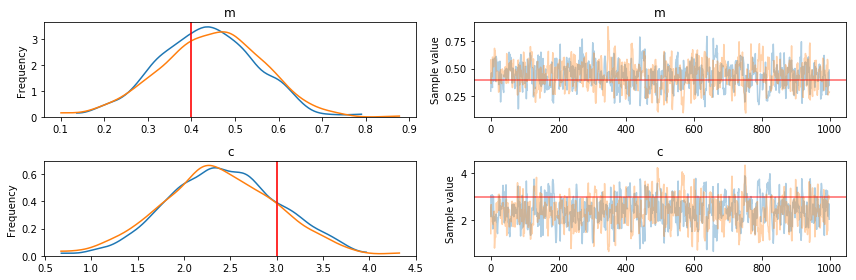

In [13]:
# plot the traces
_ = pm.traceplot(trace, lines={'m': mtrue, 'c': ctrue})